## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
!nvidia-smi

Sat Jun 20 10:49:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:

def build_mlp(
    input_shape,
    mode=True,
    acti="relu",
    dropRate=.25,
    class_num=10, 
    unitArray=[512, 256, 128, 64]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for idx, unit in enumerate(unitArray): 
        if idx == 0:
            x = keras.layers.Dense(units=unit)(input_layer)
            if mode:
                x = keras.layers.Activation(acti)(x)
                x = keras.layers.BatchNormalization()(x)
            else:
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation(acti)(x)
        else:
            x = keras.layers.Dense(units=unit)(x)
            if mode:
                x = keras.layers.Activation(acti)(x)
                x = keras.layers.BatchNormalization()(x)
            else:
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Activation(acti)(x)
    
    x = keras.layers.Dropout(dropRate)(x)
    result = keras.layers.Dense(units=class_num, activation="softmax")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[result])

    return model

In [7]:
"""Code Here
設定超參數
"""
LR = 0.001
BATCH_SIZE = [64, 128, 256]
EPOCH = 50

adam = keras.optimizers.Adam(lr=LR)


In [8]:
results = {}
permutationArray = []
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for (batch, mode) in itertools.product(BATCH_SIZE, [True, False]):

    keras.backend.clear_session()
    model = build_mlp(x_train.shape[1:], mode=mode)
    model.compile(
        optimizer=adam,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        x_train,
        y_train,
        batch_size=batch,
        epochs=EPOCH,
        validation_data=(x_test, y_test)
    )


    name = f"{batch}_{mode}"
    permutationArray.append(name)
    results[name] = {
            "acc":model.history.history["accuracy"],
            "val_acc":model.history.history["val_accuracy"],
            "loss":model.history.history["loss"],
            "val_loss":model.history.history["val_loss"]
        }


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.8428 - accuracy: 0.3524 - val_loss: 1.7013 - val_accuracy: 0.3833
Epoch 2/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6014 - accuracy: 0.4297 - val_loss: 1.7355 - val_accuracy: 0.3672
Epoch 3/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5160 - accuracy: 0.4592 - val_loss: 1.7248 - val_accuracy: 0.3926
Epoch 4/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.4546 - accuracy: 0.4836 - val_loss: 1.5180 - val_accuracy: 0.4585
Epoch 5/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.4081 - accuracy: 0.4988 - val_loss: 1.5048 - val_accuracy: 0.4646
Epoch 6/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.3614 - accuracy: 0.5182 - val_loss: 1.5502 - val_accuracy: 0.4438
Epoch 7/50
50000/50000 [==============================] - 6s 1

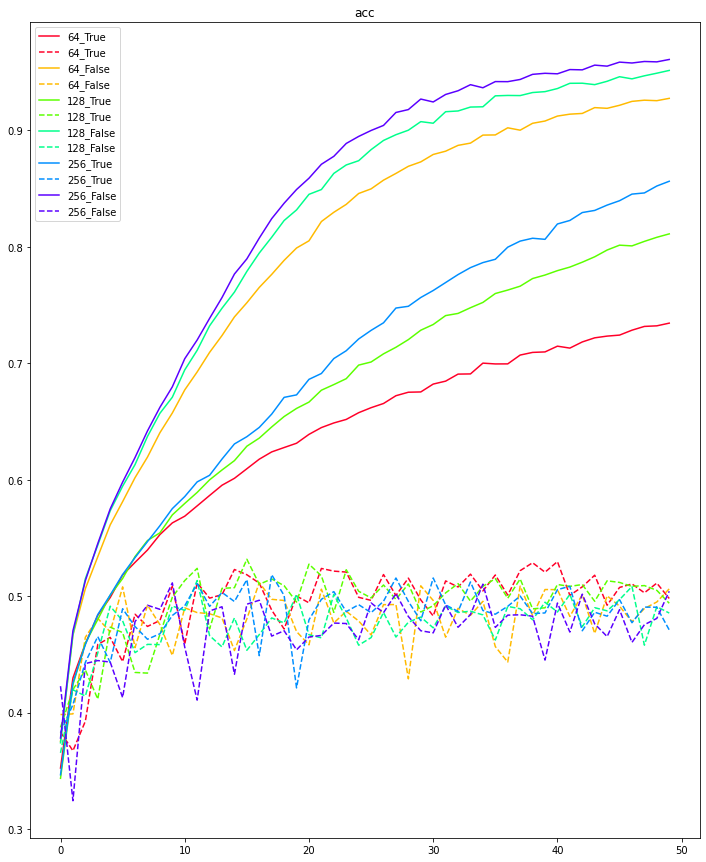

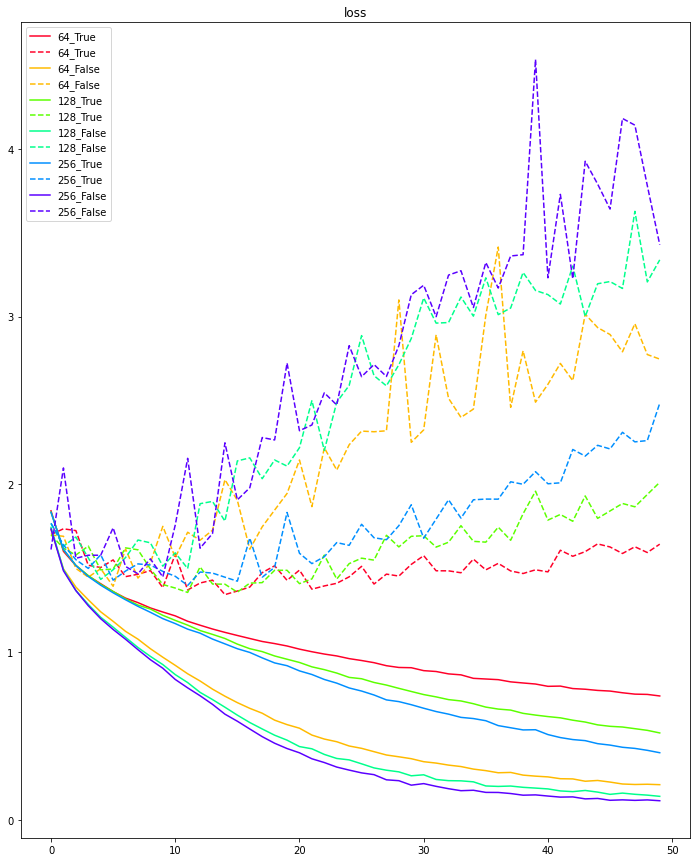

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

cm = plt.get_cmap("gist_rainbow")
colorArray = [ cm(1.0 * i/len(permutationArray)) for i in range(len(permutationArray))]

plt.figure(figsize=(12,15))
for idx, name in enumerate(permutationArray):
    plt.plot(range(EPOCH), results[name]["acc"], "-", label=name, c=colorArray[idx])
    plt.plot(range(EPOCH), results[name]["val_acc"], "--", label=name, c=colorArray[idx])
plt.title("acc")
plt.legend()
plt.show()



plt.figure(figsize=(12,15))
for idx, name in enumerate(permutationArray):
    plt.plot(range(EPOCH), results[name]["loss"], "-", label=name, c=colorArray[idx])
    plt.plot(range(EPOCH), results[name]["val_loss"], "--", label=name, c=colorArray[idx])
plt.title("loss")
plt.legend()
plt.show()